In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files = False)
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [3]:
mnist_train = mnist_train_orig.map(lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                                                tf.cast(item['label'], tf.int32)))
mnist_test = mnist_test_orig.map(lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                                                tf.cast(item['label'], tf.int32)))

In [4]:
tf.random.set_seed(1)
mnist_train = mnist_train.shuffle(buffer_size = BUFFER_SIZE,
                                 reshuffle_each_iteration = False)

In [5]:
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 32,
                                kernel_size = (5,5),
                                strides = (1,1),
                                padding = 'same',
                                data_format = 'channels_last',
                                name = 'conv_1', activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), name = 'pool_1'))
model.add(tf.keras.layers.Conv2D(filters = 64,
                                kernel_size = (5,5),
                                strides = (1,1),
                                padding = 'same',
                                name = 'conv_2',
                                activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), name = 'pool_2'))

In [7]:
# calculate size of feature map
model.compute_output_shape(input_shape = (16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [8]:
# add dense layer for classifier
# flatten first
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape = (16,28,28, 1))

TensorShape([16, 3136])

In [9]:
# add two dense layers with dropout layer in between
model.add(tf.keras.layers.Dense(units = 1024,
                              name = 'fc_l',
                              activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate = 0.5))
model.add(tf.keras.layers.Dense(units = 10,
                               name = 'fc_2',
                               activation = 'softmax'))

In [10]:
tf.random.set_seed(1)

In [12]:
model.build(input_shape = (None, 28, 28, 1))
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

In [15]:
history = model.fit(mnist_train, epochs = NUM_EPOCHS,
                   validation_data = mnist_valid,
                   shuffle = True)

Epoch 1/20
782/782 [==============================] - 106s 134ms/step - loss: 0.3113 - accuracy: 0.9017 - val_loss: 0.0466 - val_accuracy: 0.9853
Epoch 2/20
782/782 [==============================] - 91s 116ms/step - loss: 0.0483 - accuracy: 0.9853 - val_loss: 0.0384 - val_accuracy: 0.9879
Epoch 3/20
782/782 [==============================] - 83s 105ms/step - loss: 0.0304 - accuracy: 0.9898 - val_loss: 0.0431 - val_accuracy: 0.9867
Epoch 4/20
782/782 [==============================] - 89s 113ms/step - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0347 - val_accuracy: 0.9893
Epoch 5/20
782/782 [==============================] - 81s 103ms/step - loss: 0.0182 - accuracy: 0.9940 - val_loss: 0.0482 - val_accuracy: 0.9873
Epoch 6/20
782/782 [==============================] - 92s 116ms/step - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.0462 - val_accuracy: 0.9887
Epoch 7/20
782/782 [==============================] - 111s 141ms/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.0530 - val_

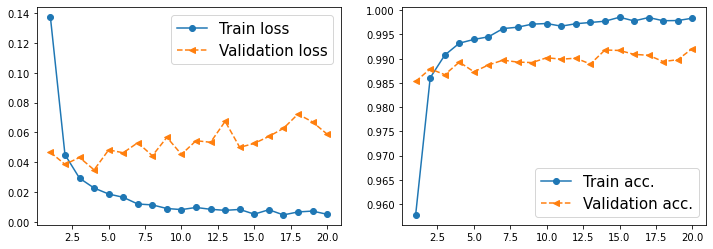

In [17]:
import numpy as np
import matplotlib.pyplot as plt
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
plt.show()

In [18]:
model.evaluate(mnist_test.batch(20))

500/500 [==============================] - 5s 10ms/step - loss: 0.0483 - accuracy: 0.9924


[0.04826177656650543, 0.9923999905586243]

In [19]:
# predict
batch_test = next(iter(mnist_test.batch(12)))
preds = model(batch_test[0])
preds = tf.argmax(preds, axis=1)

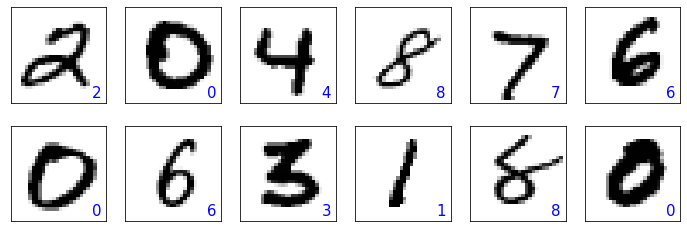

In [20]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()         